Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




Test Loader shape:torch.Size([64, 1, 28, 28])




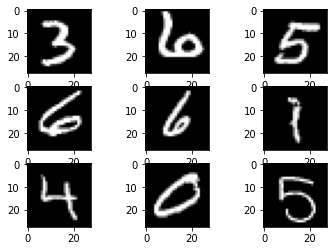

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameter
EPOCH = 10
learnig_rate = 0.001
input_size = 28*28
output_size = 10
batch_size_train = 64
batch_size_test = 1000
hidden_size = 500
log_interval = 10

# Data construction
train_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=True,
                                           transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Normalize(
                                              (0.1307,), (0.3081))
                                          ]),
                                           download=True)
                                          
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                           transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Normalize(
                                              (0.1307,), (0.3081))
                                          ]))

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size_train,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=False)

# Test
example = iter(train_loader)
example_data, example_label = example.next()
print(f'Test Loader shape:{example_data.shape}')

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()


In [3]:
# Network with 1 hidden layer
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))
    
Model = Net(input_size, hidden_size, output_size).to(device)

# loss data
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(EPOCH+1)]

# Train loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=learnig_rate)

# Train loop
def train(epoch, EPOCH):
    total_steps = len(train_loader)
    for i, (data, label) in enumerate(train_loader):
        # image shape = [64, 1, 28, 28]
        # Set the data and label to device
        data = data.reshape(-1, 28*28).to(device)
        label = label.to(device)
        
        output = Model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i) % 300 == 0:
            print (f'Epoch [{epoch+1}/{EPOCH}], Step [{i+1}/{total_steps}], Loss: {loss.item():.6f}')
        train_losses.append(loss.item())
        train_counter.append((i*batch_size_train) + ((epoch)*len(train_loader.dataset)))
      
def test():
    correct_ctr = 0
    sample_ctr = 0
    with torch.no_grad():
        for data, label in test_loader:
            
            data = data.reshape(-1, 28*28).to(device)
            label = label.to(device)
            
            # output is an array
            output = Model(data)
            test_loss = criterion(output, label)
            
            # torch.max return (value, index)
            _, predict = torch.max(output.data, 1)
            sample_ctr += label.size(0)
            correct_ctr += (predict == label).sum().item()
        test_losses.append(test_loss.item())
        acc = 100 * correct_ctr / sample_ctr
        print(f'Accuracy: {acc:.6f}%')

print(f'Random parameters:')
test()
for epoch in range(EPOCH):
  train(epoch, EPOCH)
  test()

Random parameters:
Accuracy: 11.000000%
Epoch [1/10], Step [1/938], Loss: 2.351106
Epoch [1/10], Step [301/938], Loss: 0.380203
Epoch [1/10], Step [601/938], Loss: 0.100641
Epoch [1/10], Step [901/938], Loss: 0.048191
Accuracy: 96.630000%
Epoch [2/10], Step [1/938], Loss: 0.041108
Epoch [2/10], Step [301/938], Loss: 0.096264
Epoch [2/10], Step [601/938], Loss: 0.166136
Epoch [2/10], Step [901/938], Loss: 0.008950
Accuracy: 97.250000%
Epoch [3/10], Step [1/938], Loss: 0.044098
Epoch [3/10], Step [301/938], Loss: 0.047749
Epoch [3/10], Step [601/938], Loss: 0.043327
Epoch [3/10], Step [901/938], Loss: 0.070715
Accuracy: 97.700000%
Epoch [4/10], Step [1/938], Loss: 0.006499
Epoch [4/10], Step [301/938], Loss: 0.029583
Epoch [4/10], Step [601/938], Loss: 0.007440
Epoch [4/10], Step [901/938], Loss: 0.014531
Accuracy: 97.790000%
Epoch [5/10], Step [1/938], Loss: 0.024182
Epoch [5/10], Step [301/938], Loss: 0.025287
Epoch [5/10], Step [601/938], Loss: 0.013364
Epoch [5/10], Step [901/938], L

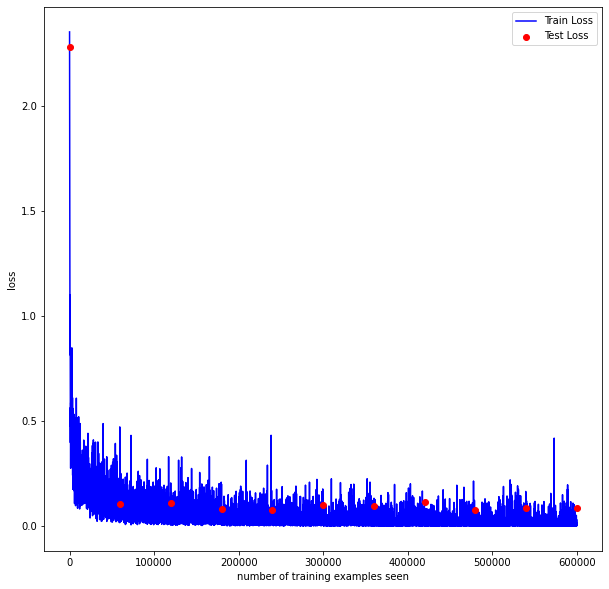

In [5]:

plt.figure(2, figsize=[10,10])
plt.scatter(test_counter, test_losses, color='r', zorder=2)
plt.plot(train_counter, train_losses, color='b', zorder=1, ms=0.5)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')
plt.show()